#Clasificación con Random Forest

**Es una tecnica que permite estimar la probabilidad de ocurrencia de un evento**

#Importacion de Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Funciones

In [2]:
def analizadorNulos(data):
    
    qFilas, qColumnas = data.shape
    if data.isnull().any().any():
        view_info = pd.DataFrame(pd.concat([data.isnull().any(), data.isnull().sum(), 
                                            round(data.isnull().sum() / qFilas * 100, 2), data.dtypes], axis=1))
        view_info.columns = ['Nulos', 'Cantidad', '%_Nulos', 'Tipo_Dato']
        view_info.sort_values(by='%_Nulos', ascending = False, inplace = True)
        display(view_info[view_info['Cantidad'] > 0])
        #Graficando el porcentaje de nulos
        plt.figure(figsize=(10,7))
        plt.title('Porcentaje de Nulos', fontsize = 15)
        plt.grid(True)
        plt.yticks(range(qColumnas + 1, 1 , -1), view_info.index, fontsize=20)
        plt.xlabel("Porcentaje de Nulos",fontsize=15)
        plt.ylabel("Variables\n",fontsize=20)
        #plt.xlim(0,100)
        plt.barh(range(qColumnas + 1, 1 , -1), width=view_info['%_Nulos'],height=0.5)
        #print(list(enumerate(view_info['%_Nulos'], 1)))
        for i, txt in enumerate(view_info['%_Nulos']):
          plt.annotate(str(txt) + '%', (txt, (qColumnas + 1 - i) ), fontsize = 12)
    else:
        print("No existen Nulos")

def analisisCategoricas(df, variable):
  frecuencia_absoluta = pd.DataFrame(df[variable].astype('str').fillna('Nulo').value_counts(dropna = False))
  frecuencia_absoluta.columns = ['FREC_ABS'] 
  #display(frecuencia_absoluta)
  frecuencia_relativa = pd.DataFrame(df[variable].astype('str').fillna('Nulo').value_counts(normalize = True, dropna = False))
  frecuencia_relativa.columns = ['FREC_REL'] 
  #display(frecuencia_relativa)
  tablaResumen = pd.concat([frecuencia_absoluta,frecuencia_relativa], axis = 1)
  display(tablaResumen)
  tablaResumen
  #Graficando las distribuciones
  plt.bar(x = tablaResumen.index, height = tablaResumen['FREC_ABS'])
  plt.xticks(rotation=-45)
  for i, txt in enumerate(tablaResumen['FREC_ABS']):
    plt.annotate(str(txt), (i, txt), fontsize = 12)
  plt.twinx()
  plt.plot(tablaResumen['FREC_REL'], linestyle='-', linewidth=2.0, color='red')
  plt.ylim(0, 1)
  for i, txt in enumerate(tablaResumen['FREC_REL']):
    plt.annotate(str(round(txt * 100, 1)) + '%', (i, txt), fontsize = 12, ha='center')
  plt.show()

def analisisNumericas(df, variable):

  print(" "*20,"Histograma"," "*20)
  df[variable].plot.hist(bins=25,figsize=(8,4))
  plt.show()
  print("\n")
  print(" "*20,"Boxplot"," "*20)
  df[variable].plot.box(figsize=(8,4))
  plt.show()

def analisisBivariante(data, variable, target, qCortes = 0):
    
    df = data.copy()
    if qCortes > 0:
      df[variable] = pd.qcut(df[variable], qCortes, duplicates='drop')
      df[variable] = df[variable].astype('str')
    if df[variable].isnull().any():
      df[variable] = df[variable].astype('str')
    prueba = pd.concat([df.groupby(variable).sum()[[target]].sort_index(),
                        df[variable].value_counts()], axis = 1)
    prueba['%_Target'] = prueba[target] / prueba[variable]
    display(prueba)
    #Graficando las distribuciones
    plt.bar(x = prueba.index, height = prueba[variable])
    plt.grid(True)
    plt.xticks(rotation=-45)
    for i, txt in enumerate(prueba[variable]):
      plt.annotate(str(txt), (i, txt), fontsize = 12)
    #plt.title(variable)
    plt.twinx()
    plt.plot(prueba['%_Target'], linestyle='-', linewidth=2.0, color='red')
    plt.ylim(0, 1)
    for i, txt in enumerate(prueba['%_Target']):
      plt.annotate(str(round(txt * 100, 1)) + '%', (i, txt), fontsize = 12, ha='center')

    # sns.boxplot(x='response', y=columna, data=df)
    plt.show()

# 1.- Comprension del Negocio

**Para este ejercicio, exploraremos los datos disponibles públicamente de [LendingClub.com] (www.lendingclub.com). Lending Club conecta a personas que necesitan dinero (prestatarios) con personas que tienen dinero (inversores). Intentamos crear un modelo para predecir el riesgo de prestar dinero a alguien con una amplia gama de datos relacionados con el crédito. Usaremos datos de préstamos de 2007-2010 y trataremos de clasificar y predecir si el prestatario devolvió el préstamo en su totalidad o no..**

# 2.- Comprension de los Datos

**En esta etapa nos avocaremos a conocer todo lo referente a los datos con los que contamos**

## 2.1.- Recopilacion de los Datos

In [3]:
#Importamos los datos
df = pd.read_csv('https://raw.githubusercontent.com/aurea-soriano/ML-Datasets/master/loan_data.csv')

In [4]:
#Visualizamos los datos
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## 2.2.- Descripcion de los Datos

Esto es lo que representan las columnas del conjunto de datos:

* **credit.policy**: 1 si el cliente cumple con los criterios de suscripción de crédito de LendingClub.com, y 0 en caso contrario.
* **purpose**: El propósito del préstamo (toma los valores "tarjeta_de_crédito", "consolidación_deuda", "educativo", "compra_principal", "pequeña_empresa" y "todos_otros").
* **int.rate**: la tasa de interés del préstamo, como una proporción (una tasa del 11% se almacenaría como 0,11). A los prestatarios que LendingClub.com considera más riesgosos se les asignan tasas de interés más altas.
* **installment**: las cuotas mensuales adeudadas por el prestatario si el préstamo está financiado.
* **log.annual.inc**: el logaritmo natural de los ingresos anuales autoinformados del prestatario.
* **dti**: La relación deuda-ingresos del prestatario (monto de la deuda dividido por los ingresos anuales).
* **fico**: La calificación crediticia FICO del prestatario.
* **days.with.cr.line**: El número de días que el prestatario ha tenido una línea de crédito.
* **revol.bal**: El saldo renovable del prestatario (monto impago al final del ciclo de facturación de la tarjeta de crédito).
* **revol.util**: Tasa de utilización de la línea renovable del prestatario (la cantidad de la línea de crédito utilizada en relación con el crédito total disponible).
* **inq.last.6mths**:  Número de consultas del prestatario por parte de los acreedores en los últimos 6 meses.
* **delinq.2yrs**:  La cantidad de veces que el prestatario ha estado atrasado 30 días o más en un pago en los últimos 2 años.
* **pub.rec**:  número de registros públicos despectivos del prestatario (declaraciones de quiebra, gravámenes fiscales o sentencias).
* **not.fully.paid**: la cantidad de interés para la clasificación, ya sea que el prestatario haya devuelto el dinero en su totalidad o no

## 2.3.- Exploracion de los Datos

**Aplicaremos diversas técnicas estadísticas para conocer más a profundidad los datos**

### 2.3.1.- Analisis de Nulos

In [5]:
analizadorNulos(df)

No existen Nulos


In [6]:
#Definimos las variables que trataremos como numericas y como categoricas
varCategoricas = ['credit.policy','purpose','pub.rec']
varNumericas = ['int.rate','installment','log.annual.inc','dti','fico','days.with.cr.line','revol.bal','revol.util',
                'inq.last.6mths','delinq.2yrs',]
#Definimos la Target
target = 'not.fully.paid'

### 2.3.2.- Analisis Univariante

**El objetivo de este analisis es caracterizar a las variables por sus estadisticos resumen principales (media, mediana, moda, etc)**

#### 2.3.2.1.- Analisis Univariante Categoricas

-------------------- credit.policy --------------------


,FREC_ABS,FREC_REL
1,7710,0.80497
0,1868,0.19503


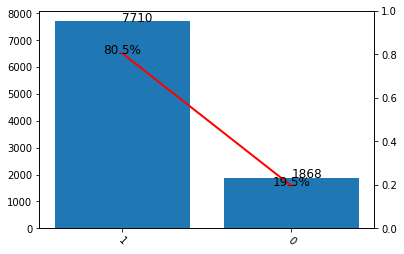




-------------------- purpose --------------------


,FREC_ABS,FREC_REL
debt_consolidation,3957,0.413134
all_other,2331,0.243370
credit_card,1262,0.131760
home_improvement,629,0.065671
small_business,619,0.064627
major_purchase,437,0.045625
educational,343,0.035811


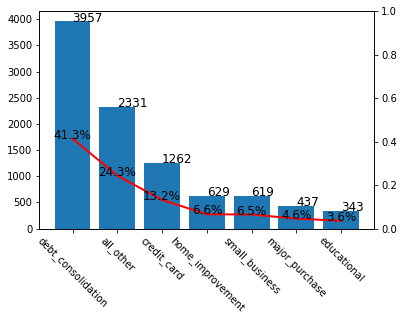




-------------------- pub.rec --------------------


,FREC_ABS,FREC_REL
0,9019,0.941637
1,533,0.055648
2,19,0.001984
3,5,0.000522
4,1,0.000104
5,1,0.000104


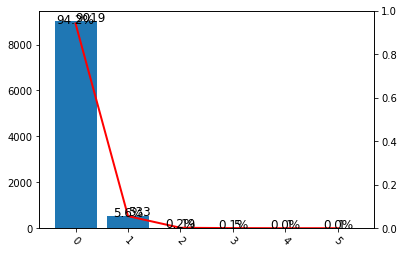

In [7]:
#Sacamos el analisis categorico para cada variable
for categorica in varCategoricas:
    print("-"*20,categorica,"-"*20)
    analisisCategoricas(df, categorica)
    print("\n\n")

#### 2.3.2.2.- Analisis Univariante Numericas

In [8]:
#Hacemos un analisis de Percentiles
df[varNumericas].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
int.rate,9578.0,0.122640,0.026847,0.060000,0.077400,0.103900,0.122100,0.140700,0.167000,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,65.559500,163.770000,268.950000,432.762500,756.265500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,9.917893,10.558414,10.928884,11.291293,11.918391,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,1.270000,7.212500,12.665000,17.950000,23.650000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,657.000000,682.000000,707.000000,737.000000,782.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,1320.041667,2820.000000,4139.958333,5730.000000,9329.958333,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,127.700000,3187.000000,8596.000000,18249.500000,57654.300000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,1.100000,22.600000,46.300000,70.900000,94.000000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000,3.300000e+01
delinq.2yrs,9578.0,0.163708,0.546215,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.300000e+01


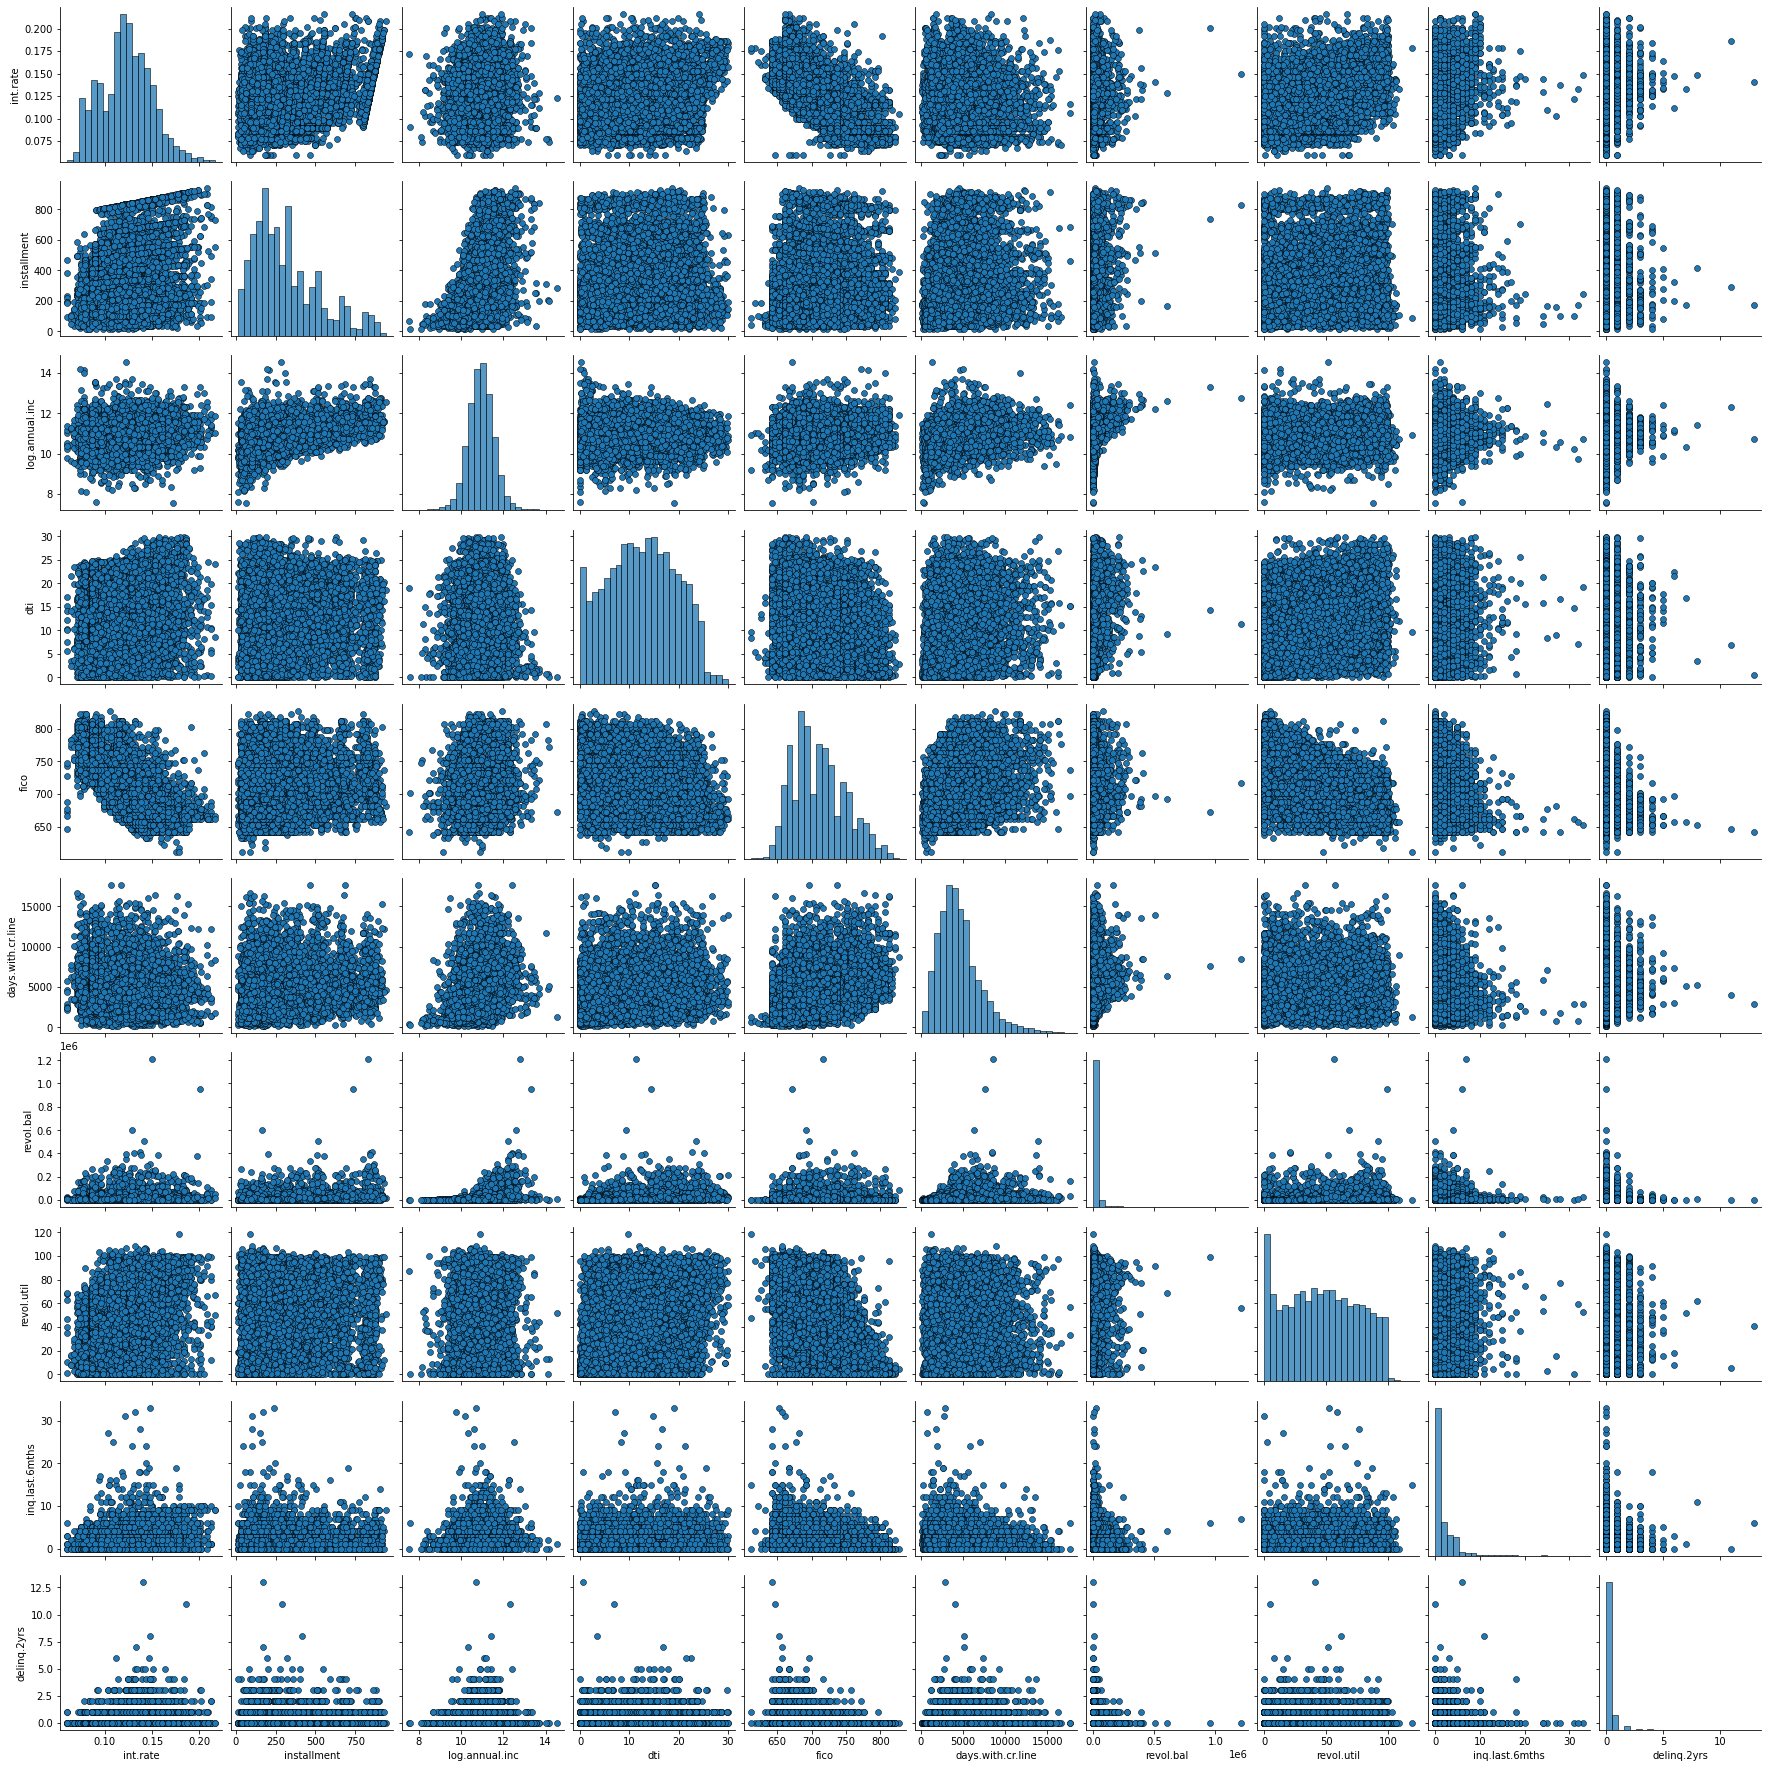

In [ ]:
sns.pairplot(data=df[varNumericas], diag_kws={'edgecolor':'k','bins':25}, plot_kws={'edgecolor':'k'})
plt.show()

#################### int.rate ####################
                     Histograma                     


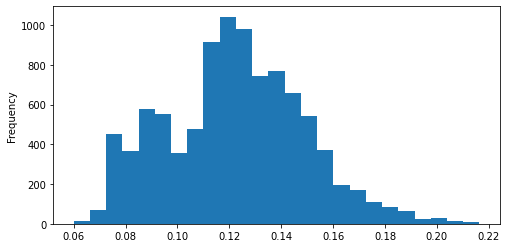



                     Boxplot                     


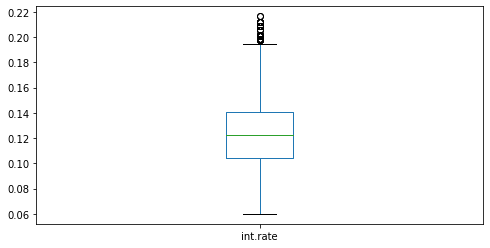




#################### installment ####################
                     Histograma                     


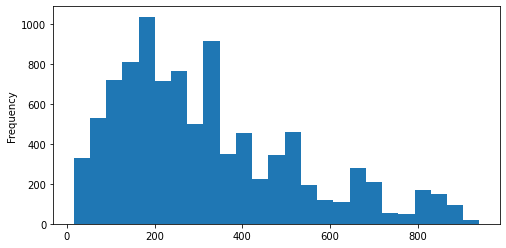



                     Boxplot                     


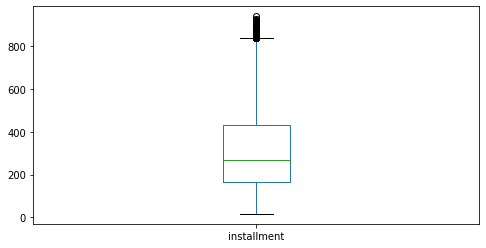




#################### log.annual.inc ####################
                     Histograma                     


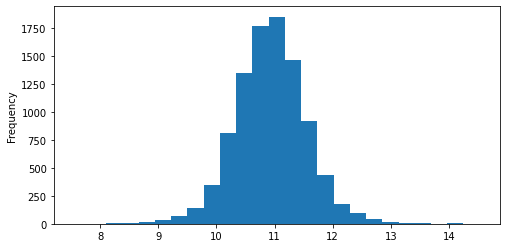



                     Boxplot                     


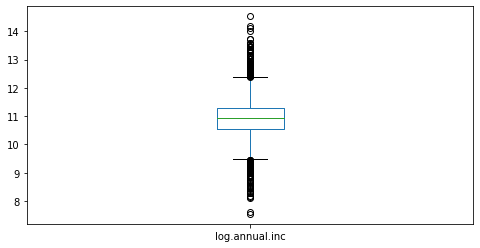




#################### dti ####################
                     Histograma                     


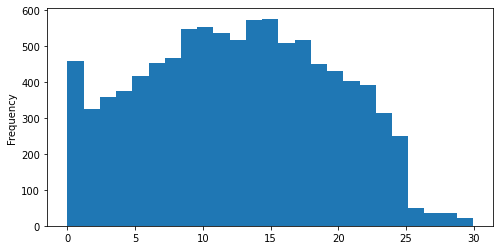



                     Boxplot                     


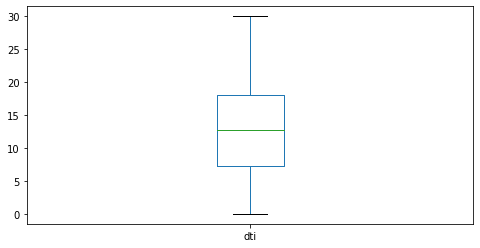




#################### fico ####################
                     Histograma                     


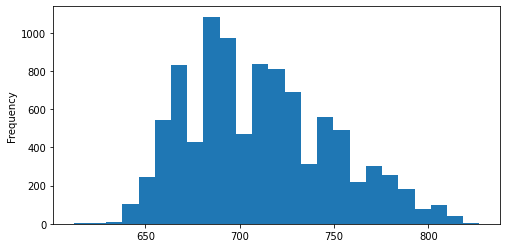



                     Boxplot                     


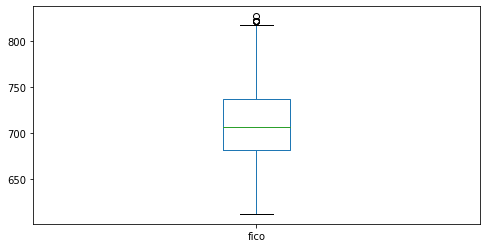




#################### days.with.cr.line ####################
                     Histograma                     


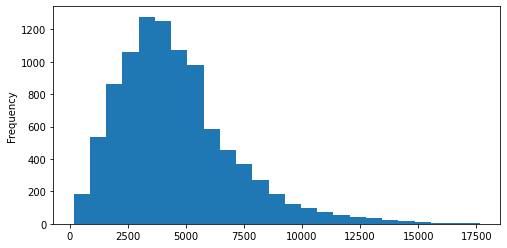



                     Boxplot                     


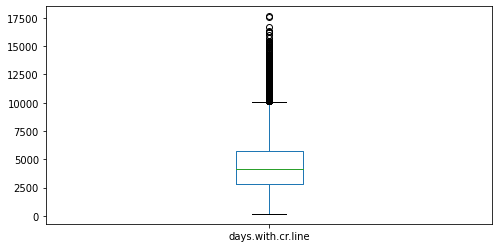




#################### revol.bal ####################
                     Histograma                     


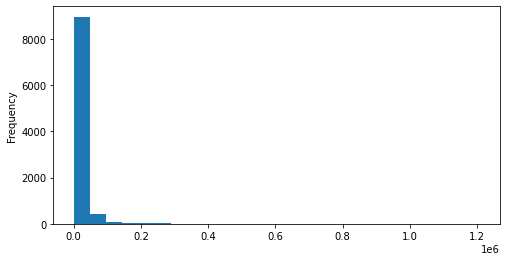



                     Boxplot                     


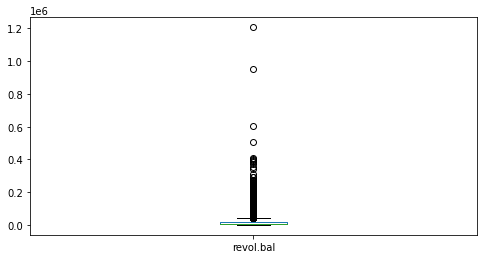




#################### revol.util ####################
                     Histograma                     


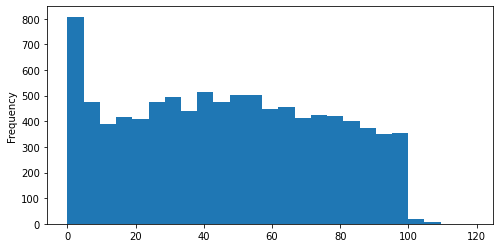



                     Boxplot                     


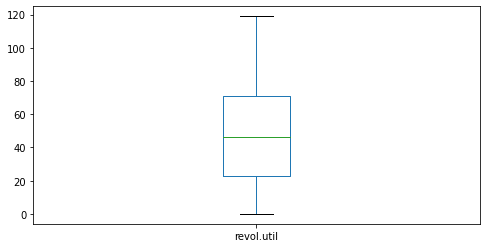




#################### inq.last.6mths ####################
                     Histograma                     


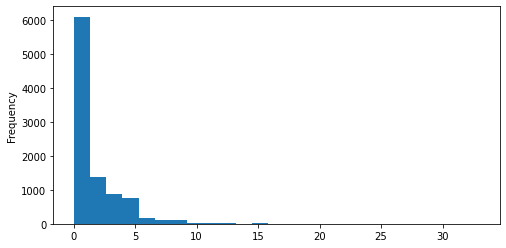



                     Boxplot                     


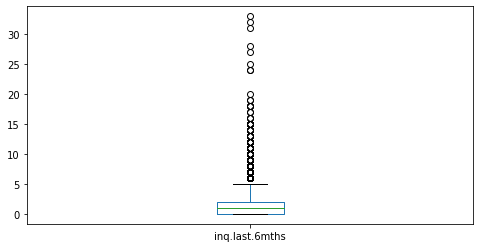




#################### delinq.2yrs ####################
                     Histograma                     


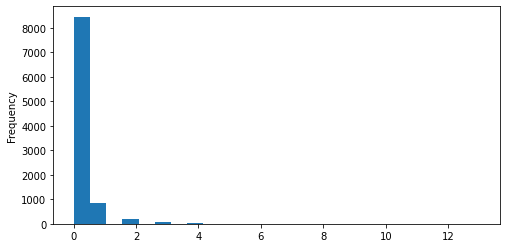



                     Boxplot                     


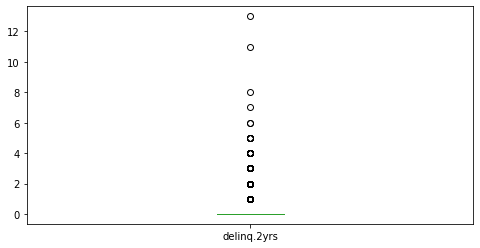

In [9]:
for numerica in varNumericas:
  print("#"*20,numerica,"#"*20)
  analisisNumericas(df, numerica)
  print("\n\n")

#### 2.3.2.2.- Analisis Univariante Target

,FREC_ABS,FREC_REL
0,8045,0.839946
1,1533,0.160054


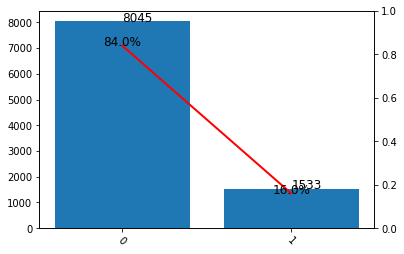

In [10]:
#Analisis Target
analisisCategoricas(df, target)

### 2.3.3.- Analisis Bivariante

**Analizamos las variables comparandolas con la variable objetivo**

#### 2.3.3.1.- Analisis Bivariante Categoricas

------------------------ credit.policy ------------------------


,not.fully.paid,credit.policy,%_Target
0,519,1868,0.277837
1,1014,7710,0.131518


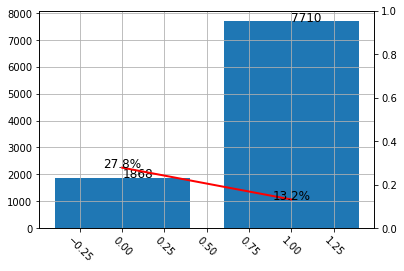




------------------------ purpose ------------------------


,not.fully.paid,purpose,%_Target
all_other,387,2331,0.166023
credit_card,146,1262,0.115689
debt_consolidation,603,3957,0.152388
educational,69,343,0.201166
home_improvement,107,629,0.170111
major_purchase,49,437,0.112128
small_business,172,619,0.277868


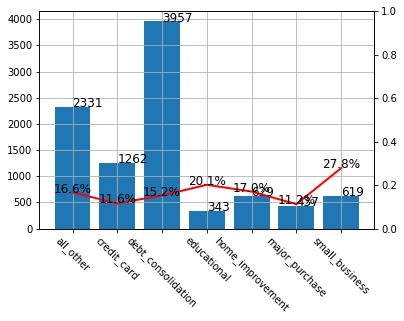




------------------------ pub.rec ------------------------


,not.fully.paid,pub.rec,%_Target
0,1395,9019,0.154673
1,136,533,0.255159
2,2,19,0.105263
3,0,5,0.000000
4,0,1,0.000000
5,0,1,0.000000


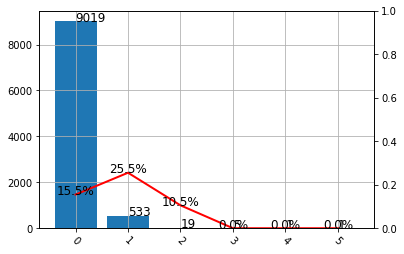

In [11]:
# Visualización Variables Numéricas:
for col in varCategoricas:
    print("------------------------",col,"------------------------")
    analisisBivariante(df, col, target)
    print("\n\n")
#analisisBivariante(df, 'Gender', target)

#### 2.3.3.2.- Analisis Bivariante Numericas

------------------------ int.rate ------------------------


,not.fully.paid,int.rate,%_Target
"(0.059, 0.0963]",134,1990,0.067337
"(0.0963, 0.117]",281,1848,0.152056
"(0.117, 0.129]",303,1960,0.154592
"(0.129, 0.144]",366,1875,0.195200
"(0.144, 0.216]",449,1905,0.235696


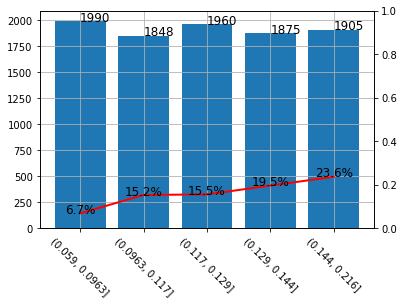




------------------------ installment ------------------------


,not.fully.paid,installment,%_Target
"(143.384, 220.5]",280,1916,0.146138
"(15.669, 143.384]",282,1916,0.147182
"(220.5, 325.45]",298,1918,0.155370
"(325.45, 495.21]",300,1923,0.156006
"(495.21, 940.14]",373,1905,0.195801


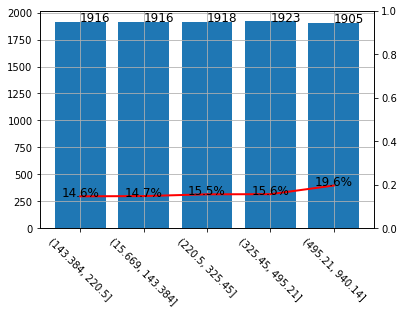




------------------------ log.annual.inc ------------------------


,not.fully.paid,log.annual.inc,%_Target
"(10.463, 10.8]",308,1896,0.162447
"(10.8, 11.082]",311,2048,0.151855
"(11.082, 11.408]",274,1874,0.146211
"(11.408, 14.528]",275,1815,0.151515
"(7.547, 10.463]",365,1945,0.187661


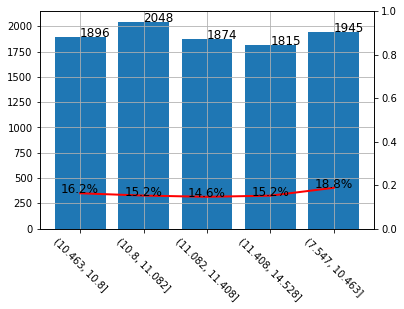




------------------------ dti ------------------------


,not.fully.paid,dti,%_Target
"(-0.001, 5.93]",283,1919,0.147473
"(10.498, 14.74]",303,1920,0.157812
"(14.74, 19.21]",302,1912,0.157950
"(19.21, 29.96]",360,1915,0.187990
"(5.93, 10.498]",285,1912,0.149059


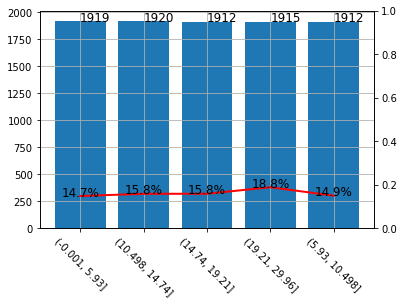




------------------------ fico ------------------------


,not.fully.paid,fico,%_Target
"(611.999, 677.0]",511,2163,0.236246
"(677.0, 697.0]",363,2058,0.176385
"(697.0, 717.0]",285,1735,0.164265
"(717.0, 742.0]",224,1716,0.130536
"(742.0, 827.0]",150,1906,0.078699


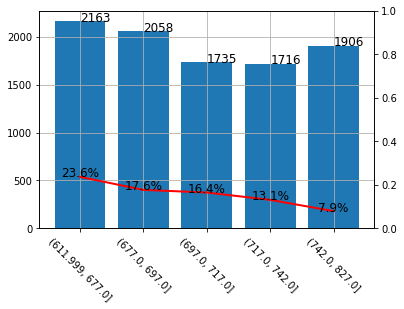




------------------------ days.with.cr.line ------------------------


,not.fully.paid,days.with.cr.line,%_Target
"(178.957, 2504.017]",333,1916,0.173800
"(2504.017, 3630.0]",308,1924,0.160083
"(3630.0, 4709.958]",322,1911,0.168498
"(4709.958, 6270.025]",281,1911,0.147043
"(6270.025, 17639.958]",289,1916,0.150835


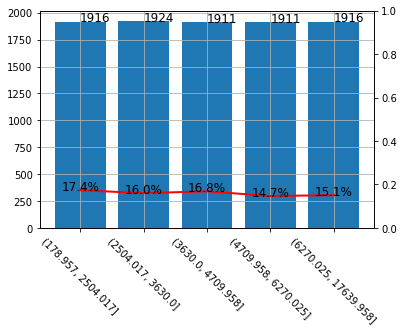




------------------------ revol.bal ------------------------


,not.fully.paid,revol.bal,%_Target
"(-0.001, 2287.0]",310,1917,0.161711
"(11587.0, 22009.6]",298,1914,0.155695
"(22009.6, 1207359.0]",353,1916,0.184238
"(2287.0, 6114.4]",297,1914,0.155172
"(6114.4, 11587.0]",275,1917,0.143453


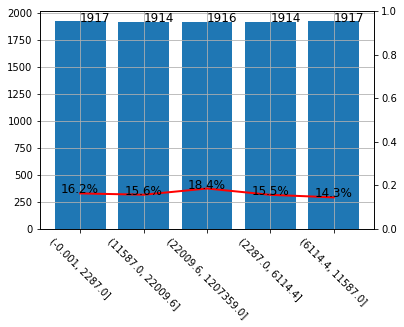




------------------------ revol.util ------------------------


,not.fully.paid,revol.util,%_Target
"(-0.001, 17.0]",229,1917,0.119457
"(17.0, 37.2]",265,1920,0.138021
"(37.2, 55.7]",315,1914,0.164577
"(55.7, 76.36]",329,1911,0.172161
"(76.36, 119.0]",395,1916,0.206159


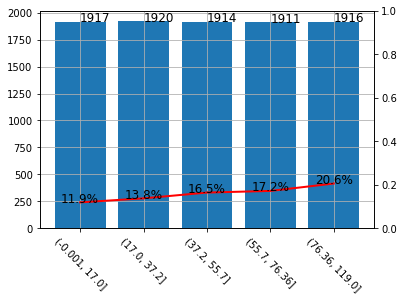




------------------------ inq.last.6mths ------------------------


,not.fully.paid,inq.last.6mths,%_Target
inq.last.6mths,,,
"(-0.001, 1.0]",799,6099,0.131005
"(1.0, 3.0]",378,2248,0.168149
"(3.0, 33.0]",356,1231,0.289196


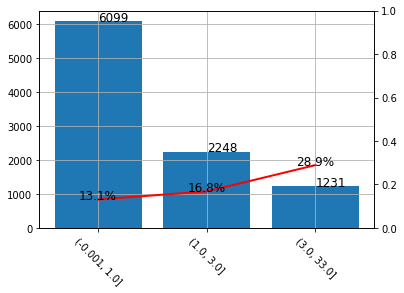




------------------------ delinq.2yrs ------------------------


,not.fully.paid,delinq.2yrs,%_Target
delinq.2yrs,,,
"(-0.001, 13.0]",1533,9578,0.160054


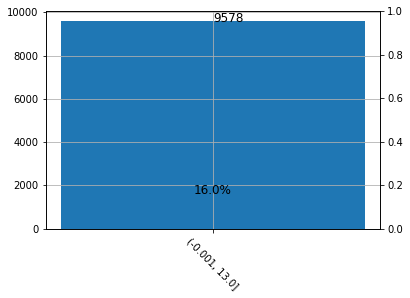

In [12]:
# Visualización Variables Numéricas:
for col in varNumericas:
    print("------------------------",col,"------------------------")
    analisisBivariante(df, col, target, 5)
    print("\n\n")
#analisisBivariante(df, 'Gender', target)

### 2.3.4.- Analisis de Correlaciones

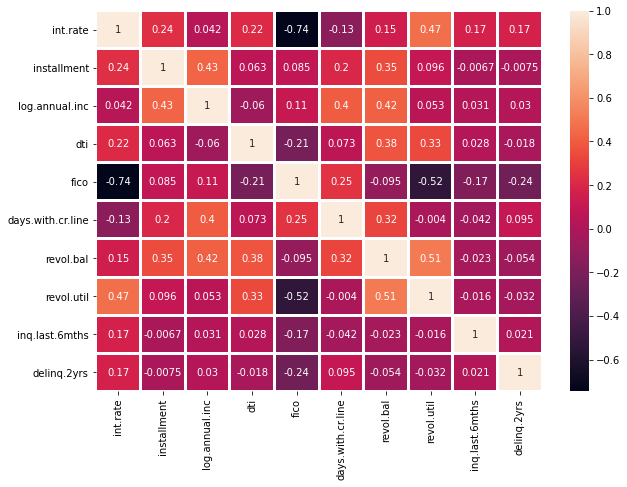

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(df[varNumericas].corr(method='spearman'), annot=True, linewidths=2)

# 3.- Preparacion de los datos

**Nos centraremos en generar el conjunto de datos con el cual entrenamos en nuestro modelo**

## 3.1.- Seleccion de los Datos

**Usaremos todas las variables para las siguientes etapas a excepcion del ID**

In [15]:
#Nos quedaremos con una lista de predictoras y la target
predictoras = ['credit.policy','purpose','pub.rec','int.rate','installment','log.annual.inc','dti','fico',
               'days.with.cr.line','revol.bal','revol.util','inq.last.6mths','delinq.2yrs']
target = 'Loan_Status'

## 3.2.- Limpieza de Datos

**Corregimos anomalías como datos perdidos o valores outliers**

### 3.2.1.- Limpieza de Missings

In [16]:
#Volvemos a revisar los nulos
analizadorNulos(df)

No existen Nulos


### 3.2.1.- Tratamiento de Outliers

**Podemos topear la variable o discretizar**

In [17]:
# Como usaremos random forest, este algortimo basado en arbol es fuerte contra outliers

In [18]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## 3.3.- Ingeniería de Variables

In [24]:
#Creamos dummies para la variable categorica Proposito del prestamo
df = pd.concat([df, pd.get_dummies(df['purpose'])], axis=1)
#Sacamos la exponencial al logaritmo natural para tener los ingresos en moneda real
df['ingreso_anual'] = np.exp(df['log.annual.inc'])
#Creamos para variable porcentaje de couta mensual
df['PCT_Cuota'] = df['installment'] / (df['ingreso_anual'] / 12)

In [25]:
#Visualizamos las nuevas variables
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business,ingreso_anual,PCT_Cuota
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0,85000.000385,0.117049
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0,65000.000073,0.042133
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0,31999.999943,0.137573
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0,85000.000385,0.022919
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0,80799.999636,0.015285


## 3.4.- Formateo de los Datos

In [19]:
#Todos los datos son numericos
df.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

In [ ]:
df.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid',
       'all_other', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'major_purchase', 'small_business', 'ingreso_anual',
       'PCT_Cuota'],
      dtype='object')

# 4.- Modelado

**Nuestro objetivo principal es obtener el modelo**

In [26]:
#Elegimos las variables predictoras y la target
predictoras = ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal',
               'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'all_other', 'credit_card', 'debt_consolidation',
               'educational', 'home_improvement', 'major_purchase', 'small_business', 'ingreso_anual', 'PCT_Cuota']
target = 'not.fully.paid'

In [27]:
# Obtenemos del dataframe el conjunto de datos
X = df[predictoras]
y = df[target]
#Visualizamos las variables predictoras
print('\n\nVisualizamos la variable predictora/independiente (X)')
display(X)
print('\n\nVisualizamos la variable respuesta/dependiente (Y)')
y



Visualizamos la variable predictora/independiente (X)


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business,ingreso_anual,PCT_Cuota
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0,85000.000385,0.117049
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0,65000.000073,0.042133
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0,31999.999943,0.137573
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0,85000.000385,0.022919
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0,80799.999636,0.015285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,0,0,0,0,0,0,195000.000479,0.021216
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,0,0,0,0,0,0,68999.999753,0.044817
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,0,0,1,0,0,0,0,39999.999876,0.029343
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,0,0,0,0,1,0,0,49999.999779,0.084379




Visualizamos la variable respuesta/dependiente (Y)


0       0
1       0
2       0
3       0
4       0
       ..
9573    1
9574    1
9575    1
9576    1
9577    1
Name: not.fully.paid, Length: 9578, dtype: int64

In [28]:
# Generamos el conjunto de train y test gracias a sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [29]:
#Revisamos los tamaños de las pruebas de train y test
print("Tamaño del conjunto de datos Inicial:", df.shape)
print("Tamaño del conjunto de características del entrenamiento:",X_train.shape)
print("Tamaño del conjunto de características de prueba:",X_test.shape)
print("Tamaño de la variable objetivo del entrenamiento:",y_train.shape)
print("Tamaño de la variable objetivo de prueba:",y_test.shape)

Tamaño del conjunto de datos Inicial: (9578, 23)
Tamaño del conjunto de características del entrenamiento: (6704, 21)
Tamaño del conjunto de características de prueba: (2874, 21)
Tamaño de la variable objetivo del entrenamiento: (6704,)
Tamaño de la variable objetivo de prueba: (2874,)


## 4.1.- Regresion Logistica

### 4.1.1.- Regresion Logistica por Gradiente del Descenso

In [30]:
# Importamos el Modelo de Regresion Logistica
from sklearn.linear_model import LogisticRegression
# Importamos las metricas de los modelos
from sklearn import metrics
# Creamos el modelo de la regresion
lr = LogisticRegression() # Creando un objeto de Regresión Logistica 'lr'

In [31]:
# Entrenamiento del modelo
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Verificamos la intercepción y los coeficientes y los colocamos en un DataFrame**

In [32]:
print("El término de intersección del modelo lineal:", lr.intercept_)
print("Los coeficientes del modelo lineal:", lr.coef_)

El término de intersección del modelo lineal: [1.64935725e-05]
Los coeficientes del modelo lineal: [[-1.85858445e-04  1.17632209e-05  8.96676341e-04  9.62972708e-05
   4.25205171e-04 -2.89956320e-03 -2.24728528e-05  3.26614044e-06
   5.98531422e-03  1.11914078e-03  2.24446204e-05  4.54174277e-05
   4.21477222e-05 -5.55328984e-05 -3.94825856e-05  2.10495915e-05
   8.81401752e-06 -1.46681844e-05  5.41659138e-05 -2.95227755e-06
   6.18013411e-06]]


In [33]:
# Predecimos la data de entrenamiento y la data del test
train_pred=lr.predict(X_train)
test_pred=lr.predict(X_test)
#predict_proba()

In [34]:
#Vemos la matriz de confusion del train y el test
from sklearn.metrics import classification_report, confusion_matrix
print('Visualizando la matriz de confusion del train:\n')
print(confusion_matrix(y_train, train_pred))
print('\nVisualizando la matriz de confusion del test:\n')
print(confusion_matrix(y_test, test_pred))

Visualizando la matriz de confusion del train:

[[5650    1]
 [1053    0]]

Visualizando la matriz de confusion del test:

[[2394    0]
 [ 479    1]]


In [35]:
# Calculando las principales metricas
print("Calculando el Accuracy o Precision Global del Modelo")
print("Accuracy del Train:", metrics.accuracy_score(y_train,train_pred))
print("Accuracy del Test:", metrics.accuracy_score(y_test,test_pred))
print("\nCalculando la Sensibilidad o Recall")
print("Sensibilidad del Train:", metrics.recall_score(y_train,train_pred))
print("Sensibilidad del Test:", metrics.recall_score(y_test,test_pred))
print("\nCalculando la Precision del Modelo")
print("Precision del Train:", metrics.precision_score(y_train,train_pred))
print("Precision del Test:", metrics.precision_score(y_test,test_pred))

Calculando el Accuracy o Precision Global del Modelo
Accuracy del Train: 0.8427804295942721
Accuracy del Test: 0.8333333333333334

Calculando la Sensibilidad o Recall
Sensibilidad del Train: 0.0
Sensibilidad del Test: 0.0020833333333333333

Calculando la Precision del Modelo
Precision del Train: 0.0
Precision del Test: 1.0


### 4.1.2.- Random Forest

In [36]:
# Importamos el Modelo de Regresion Logistica
from sklearn.ensemble import RandomForestClassifier
# Importamos las metricas de los modelos
from sklearn import metrics
# Creamos el modelo de la regresion
rf = RandomForestClassifier(random_state = 123) # Creando un objeto de ranfom forest Logistica 'rf'

In [37]:
# Entrenamiento del modelo
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [38]:
# Predecimos la data de entrenamiento y la data del test
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)
# Predecimos las probabilidades
train_pred_proba = rf.predict_proba(X_train)
test_pred_proba = rf.predict_proba(X_test)

In [39]:
#Vemos la matriz de confusion del train y el test
from sklearn.metrics import classification_report, confusion_matrix
print('Visualizando la matriz de confusion del train:\n')
print(confusion_matrix(y_train, train_pred))
print('\nVisualizando la matriz de confusion del test:\n')
print(confusion_matrix(y_test, test_pred))

Visualizando la matriz de confusion del train:

[[5651    0]
 [   0 1053]]

Visualizando la matriz de confusion del test:

[[2385    9]
 [ 471    9]]


In [40]:
# Calculando las principales metricas
print("Calculando el Accuracy o Precision Global del Modelo")
print("Accuracy del Train:", metrics.accuracy_score(y_train,train_pred))
print("Accuracy del Test:", metrics.accuracy_score(y_test,test_pred))
print("\nCalculando la Sensibilidad o Recall")
print("Sensibilidad del Train:", metrics.recall_score(y_train,train_pred))
print("Sensibilidad del Test:", metrics.recall_score(y_test,test_pred))
print("\nCalculando la Precision del Modelo")
print("Precision del Train:", metrics.precision_score(y_train,train_pred))
print("Precision del Test:", metrics.precision_score(y_test,test_pred))

Calculando el Accuracy o Precision Global del Modelo
Accuracy del Train: 1.0
Accuracy del Test: 0.8329853862212944

Calculando la Sensibilidad o Recall
Sensibilidad del Train: 1.0
Sensibilidad del Test: 0.01875

Calculando la Precision del Modelo
Precision del Train: 1.0
Precision del Test: 0.5


### 4.1.2.- Random Forest con GridSearh

In [41]:
#Importamos el método GridSearch
from sklearn.model_selection import GridSearchCV
#Definimos los parametos del Gread Search
params = {'n_estimators':[10, 50, 100, 150, 200],
          'max_depth':list(range(2,11)),
          'min_samples_leaf':[x / 100 for x in range(1, 11)]}
#Creamos el Objeto gread search
grid = GridSearchCV(rf, param_grid=params, scoring='accuracy', verbose=1, return_train_score=True)

In [42]:
#Entrenando con GridSearch
grid.fit(X_train,y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 18.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=123,
                              

In [ ]:
#Obtenemos el mejor estimador
grid.best_estimator_
#Obtenemos los mejores hiperparametos
grid.best_params_

{'max_depth': 2, 'min_samples_leaf': 0.01, 'n_estimators': 10}

In [ ]:
#Probamos el mejor estimador
rf = RandomForestClassifier(max_depth= 2, min_samples_leaf = 0.01, n_estimators=10, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [ ]:
# Predecimos la data de entrenamiento y la data del test
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)
# Predecimos las probabilidades
train_pred_proba = rf.predict_proba(X_train)
test_pred_proba = rf.predict_proba(X_test)

In [ ]:
# Calculando las principales metricas
print("Calculando el Accuracy o Precision Global del Modelo")
print("Accuracy del Train:", metrics.accuracy_score(y_train,train_pred))
print("Accuracy del Test:", metrics.accuracy_score(y_test,test_pred))
print("\nCalculando la Sensibilidad o Recall")
print("Sensibilidad del Train:", metrics.recall_score(y_train,train_pred))
print("Sensibilidad del Test:", metrics.recall_score(y_test,test_pred))
print("\nCalculando la Precision del Modelo")
print("Precision del Train:", metrics.precision_score(y_train,train_pred))
print("Precision del Test:", metrics.precision_score(y_test,test_pred))

Calculando el Accuracy o Precision Global del Modelo
Accuracy del Train: 0.8429295942720764
Accuracy del Test: 0.8329853862212944

Calculando la Sensibilidad o Recall
Sensibilidad del Train: 0.0
Sensibilidad del Test: 0.0

Calculando la Precision del Modelo
Precision del Train: 0.0
Precision del Test: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


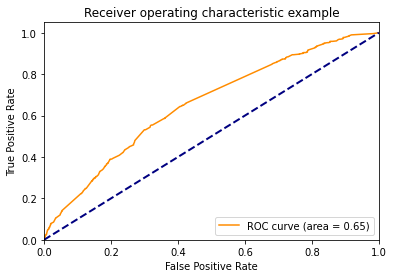

In [ ]:
#Sacando la Curva ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred_proba[:,1])
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(y_test, test_pred_proba[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Obteniendo la Curva ROC y el AUC y el GINI
print("\nCalculando el AUC del Modelo")
print("AUC del Train:", metrics.roc_auc_score(y_train, train_pred_proba[:,1]))
print("AUC del Test:", metrics.roc_auc_score(y_test, test_pred_proba[:,1]))
print("\nCalculando el GINI del Modelo")
print("GINI del Train:", 2 * metrics.roc_auc_score(y_train, train_pred_proba[:,1]) - 1)
print("GINI del Test:", 2 * metrics.roc_auc_score(y_test, test_pred_proba[:,1]) - 1)


Calculando el AUC del Modelo
AUC del Train: 0.6728561434218251
AUC del Test: 0.6541932087162351

Calculando el GINI del Modelo
GINI del Train: 0.3457122868436502
GINI del Test: 0.3083864174324702


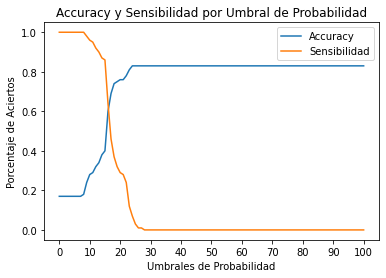

In [ ]:
#Obteniendo el mejor punto de corte
listAccuracy = []
listSensibilidad = []
for umbral in [prob/100 for prob in range(101)]:
  #print(umbral)  
  test_pred=(test_pred_proba[:,1] > umbral).astype(int)
  listAccuracy.append(round(metrics.accuracy_score(y_test,test_pred), 2))
  listSensibilidad.append(round(metrics.recall_score(y_test,test_pred), 2))
#print(listAccuracy)
#print(listSensibilidad)

#plt.plot(listAccuracy, listSensibilidad, color='darkorange', #label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(y_test,test_pred_proba))
plt.plot(listAccuracy, label = 'Accuracy')
plt.plot(listSensibilidad, label = 'Sensibilidad')
#plt.plot([50, 50], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('Umbrales de Probabilidad')
plt.ylabel('Porcentaje de Aciertos')
plt.title('Accuracy y Sensibilidad por Umbral de Probabilidad')
plt.xticks([x for x in range(0, 101, 10)])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.legend(loc="upper right")
plt.show()

In [ ]:
#Mostrando en mejor punto de corte
dfMetricas = pd.DataFrame({'corte':[prob/100 for prob in range(101)], 'Accuracy':listAccuracy, 'Sensibilidad':listSensibilidad})
dfMetricas['Acc_Sen'] = (dfMetricas['Accuracy'] + dfMetricas['Sensibilidad']) / 2
dfMetricas.sort_values(by='Acc_Sen', ascending=False)

,corte,Accuracy,Sensibilidad,Acc_Sen
15,0.15,0.40,0.86,0.630
14,0.14,0.38,0.87,0.625
11,0.11,0.29,0.95,0.620
10,0.10,0.28,0.96,0.620
16,0.16,0.60,0.64,0.620
...,...,...,...,...
51,0.51,0.83,0.00,0.415
49,0.49,0.83,0.00,0.415
48,0.48,0.83,0.00,0.415
47,0.47,0.83,0.00,0.415
